# FastText Experimenty

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!unzip '../Data/wiki-news-300d-1M.vec.zip'

Archive:  /content/drive/MyDrive/DP/Data/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('../Data/final_dataset_5.csv')

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoder

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
y_test.shape

(352, 81)

## Embdding matica

In [ ]:
embeddings_index = {}
with open('wiki-news-300d-1M.vec') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 999995 word vectors.


In [ ]:
embedding_dim = 300
vocab_size = 40000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 34019 words (5981 misses)


# Modely

## DNN model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 300)         12000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
40/40 [==============================] - 90s 2s/step - loss: 4.2038 - accuracy: 0.0805 - val_loss: 3.9478 - val_accuracy: 0.1631
Epoch 2/15
40/40 [==============================] - 85s 2s/step - loss: 4.0131 - accuracy: 0.1405 - val_loss: 3.7039 - val_accuracy: 0.2695
Epoch 3/15
40/40 [==============================] - 86s 2s/step - loss: 3.7316 - accuracy: 0.1721 - val_loss: 3.3280 - val_accuracy: 0.2695
Epoch 4/15
40/40 [==============================] - 85s 2s/step - loss: 3.3549 - accuracy: 0.2234 - val_loss: 3.0105 - val_accuracy: 0.3121
Epoch 5/15
40/40 [==============================] - 85s 2s/step - loss: 2.9726 - accuracy: 0.2841 - val_loss: 2.7689 - val_accuracy: 0.4184
Epoch 6/15
40/40 [==============================] - 85s 2s/step - loss: 2.6472 - accuracy: 0.3504 - val_loss: 2.5373 - val_accuracy: 0.3901
Epoch 7/15
40/40 [==============================] - 86s 2s/step - loss: 2.4247 - accuracy: 0.3938 - val_loss: 2.3300 - val_accuracy: 0.4823
Epoch 8/15
40/40 [==

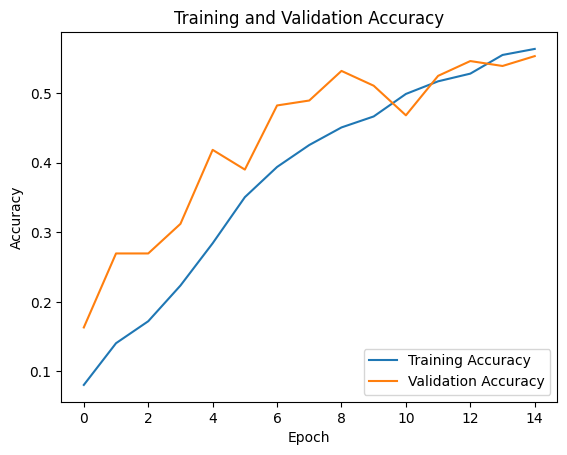

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 1s 54ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6079545454545454
F1 Score: 0.5760744596622355
Precision: 0.5855836366915912
Recall: 0.6079545454545454


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 conv1d (Conv1D)             (None, 5997, 512)         614912    
                                                                 
 max_pooling1d (MaxPooling1  (None, 2998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d_1  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
40/40 [==============================] - 96s 2s/step - loss: 4.2089 - accuracy: 0.0852 - val_loss: 3.9474 - val_accuracy: 0.2695
Epoch 2/15
40/40 [==============================] - 87s 2s/step - loss: 3.9626 - accuracy: 0.1389 - val_loss: 3.6447 - val_accuracy: 0.2695
Epoch 3/15
40/40 [==============================] - 87s 2s/step - loss: 3.7144 - accuracy: 0.1934 - val_loss: 3.4004 - val_accuracy: 0.3121
Epoch 4/15
40/40 [==============================] - 88s 2s/step - loss: 3.4615 - accuracy: 0.2084 - val_loss: 3.1382 - val_accuracy: 0.3191
Epoch 5/15
40/40 [==============================] - 88s 2s/step - loss: 3.2098 - accuracy: 0.2573 - val_loss: 2.9303 - val_accuracy: 0.3830
Epoch 6/15
40/40 [==============================] - 87s 2s/step - loss: 2.9344 - accuracy: 0.3173 - val_loss: 2.7044 - val_accuracy: 0.3759
Epoch 7/15
40/40 [==============================] - 87s 2s/step - loss: 2.7071 - accuracy: 0.3662 - val_loss: 2.4224 - val_accuracy: 0.4539
Epoch 8/15
40/40 [==

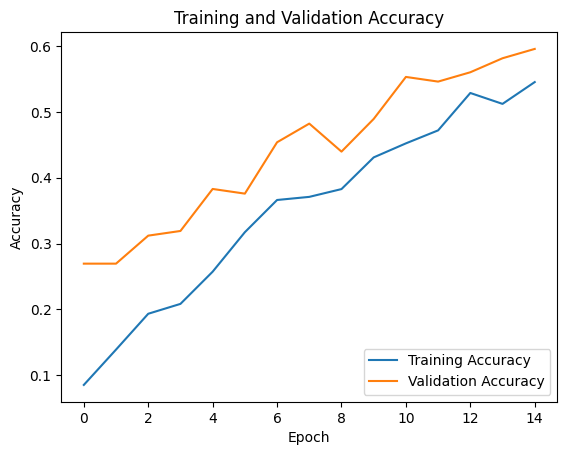

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 1s 72ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6079545454545454
F1 Score: 0.5779299327720232
Precision: 0.5888314761349414
Recall: 0.6079545454545454


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Biderectional LSTMU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 bidirectional (Bidirection  (None, 6000, 256)         439296    
 al)                                                             
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
40/40 [==============================] - 103s 3s/step - loss: 4.2849 - accuracy: 0.0560 - val_loss: 4.0112 - val_accuracy: 0.1277
Epoch 2/15
40/40 [==============================] - 98s 3s/step - loss: 4.0286 - accuracy: 0.1105 - val_loss: 3.5741 - val_accuracy: 0.2624
Epoch 3/15
40/40 [==============================] - 98s 2s/step - loss: 3.8860 - accuracy: 0.1476 - val_loss: 3.4979 - val_accuracy: 0.2837
Epoch 4/15
40/40 [==============================] - 15s 387ms/step - loss: 3.6642 - accuracy: 0.1768 - val_loss: 3.5075 - val_accuracy: 0.2482
Epoch 5/15
40/40 [==============================] - 98s 2s/step - loss: 3.4972 - accuracy: 0.1918 - val_loss: 3.2272 - val_accuracy: 0.3050
Epoch 6/15
40/40 [==============================] - 98s 2s/step - loss: 3.3076 - accuracy: 0.2360 - val_loss: 3.0469 - val_accuracy: 0.3830
Epoch 7/15
40/40 [==============================] - 98s 2s/step - loss: 3.0924 - accuracy: 0.2502 - val_loss: 2.8848 - val_accuracy: 0.3901
Epoch 8/15
40/40

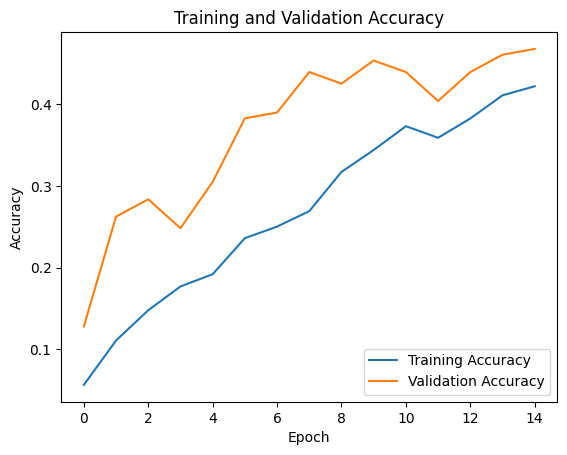

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 3s 180ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.4744318181818182
F1 Score: 0.4147419375915604
Precision: 0.4059553296694445
Recall: 0.4744318181818182


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 lstm_1 (LSTM)               (None, 6000, 256)         570368    
                                                                 
 dropout_5 (Dropout)         (None, 6000, 256)         0         
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
40/40 [==============================] - 104s 3s/step - loss: 4.3602 - accuracy: 0.0639 - val_loss: 4.2381 - val_accuracy: 0.1277
Epoch 2/15
40/40 [==============================] - 99s 3s/step - loss: 4.2393 - accuracy: 0.0860 - val_loss: 4.0058 - val_accuracy: 0.1277
Epoch 3/15
40/40 [==============================] - 99s 3s/step - loss: 4.1229 - accuracy: 0.0939 - val_loss: 3.9221 - val_accuracy: 0.1277
Epoch 4/15
40/40 [==============================] - 17s 416ms/step - loss: 4.0227 - accuracy: 0.0971 - val_loss: 3.9618 - val_accuracy: 0.1277
Epoch 5/15
40/40 [==============================] - 100s 3s/step - loss: 3.9749 - accuracy: 0.1066 - val_loss: 3.8370 - val_accuracy: 0.1348
Epoch 6/15
40/40 [==============================] - 17s 417ms/step - loss: 3.9222 - accuracy: 0.1097 - val_loss: 3.8415 - val_accuracy: 0.1348
Epoch 7/15
40/40 [==============================] - 99s 3s/step - loss: 3.8402 - accuracy: 0.1192 - val_loss: 3.8216 - val_accuracy: 0.1560
Epoch 8/15
4

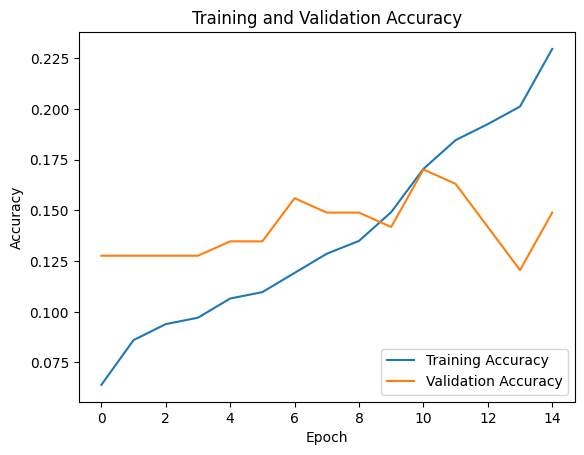

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 3s 198ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.13920454545454544
F1 Score: 0.08000530884382094
Precision: 0.05819928240942623
Recall: 0.13920454545454544
